In [9]:
%matplotlib inline

import os
import json
import matplotlib
import numpy as np
import scipy.stats
import pandas as pd
from collections import Counter

In [10]:
epsList = ['0', '0.5', '1', '1.5', '2', '3', '4']
# TODO: CHANGE THIS AS WE ANALYZE MORE SAMPLES
numSamples = 100
correctList = ['Valid Eps 0 Classification']

df = pd.DataFrame(index=[str(i) for i in range(numSamples)])
for eps in epsList:
    jsonPath = "results/sample%d/ndppca_eps_%s_600_amortized.json" % (numSamples, eps)
    dfNew = pd.read_json(path_or_buf=jsonPath, orient='columns')
    df = df.join(other=dfNew, how='right')
    
    # Add a column to indicate which samples were classified correctly
    prefix = 'Eps %s' % eps
    colList = ['Adv%d %s Classification' % (i, prefix) for i in range(9)]
    df['%s Correct Classification' % prefix] = 45 - df[colList].sum(axis=1)
    df['%s Correct' % prefix] = (df['%s Correct Classification' % prefix] == df['Valid %s Classification' % prefix])
    correctList.append('%s Correct' % prefix)
df[correctList]

ValueError: Expected object or value

In [3]:
# Only care about rows where both models classified correctly.
dfDict = {}
zeroCorrect = "Eps 0 Correct"
for eps in epsList:
    if eps is '0':
        continue
        
    epsCorrect = "Eps %s Correct" % eps
    dfDict[eps] = df[df[zeroCorrect] & df[epsCorrect]]

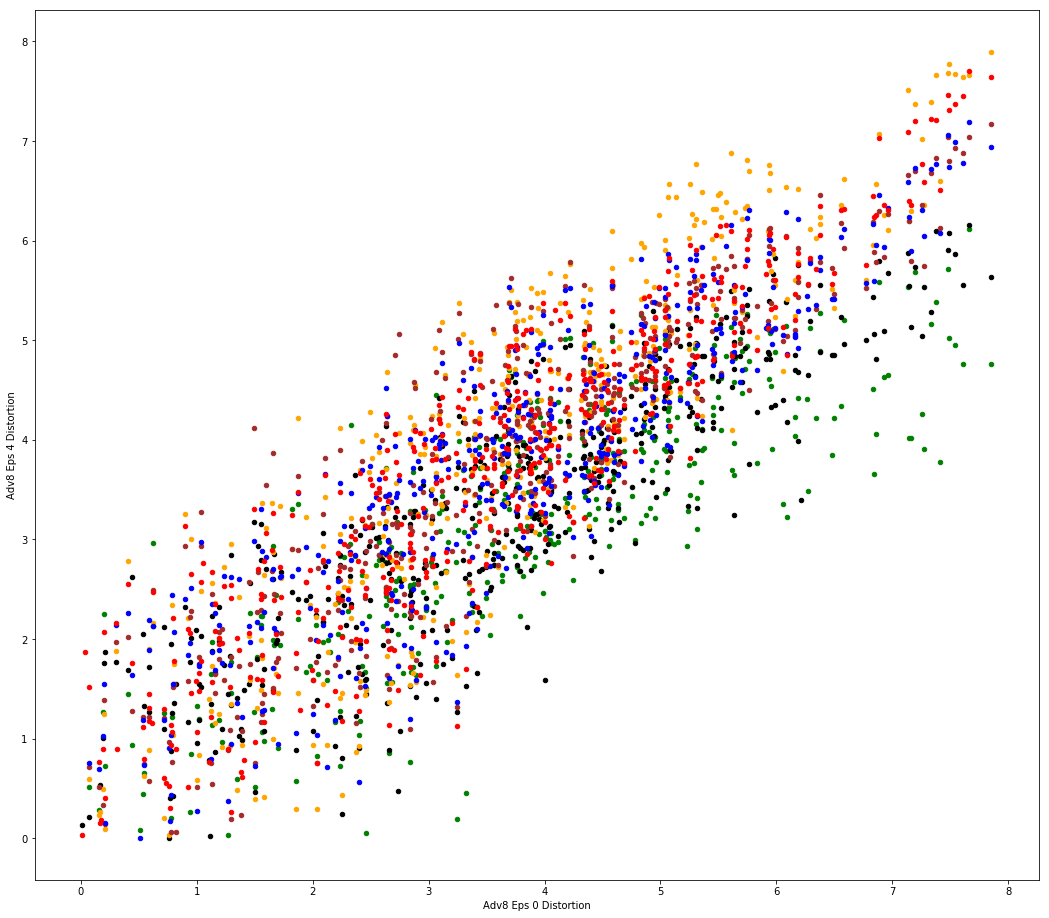

In [4]:
# TODO: Save plots separately, maybe plot regression lines as well?
ax = None
colorMap = {'0.5': 'green', '1': 'black', '1.5': 'orange', '2': 'brown', '3': 'blue', '4': 'red'}

for eps in dfDict:  
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        
        if ax is None:
            ax = dfDict[eps].plot(kind='scatter', x=zeroLabel, y=epsLabel, c=colorMap[eps], figsize=(18, 16))
        else:
            dfDict[eps].plot(kind='scatter', x=zeroLabel, y=epsLabel, c=colorMap[eps], ax=ax, figsize=(18, 16))

In [5]:
# TODO: Plot the regression lines
slopeDict = {}
interceptDict = {}
for eps in dfDict:
    x = []
    y = []
    for i in range(9):
        xLabel = "Adv%d Eps 0 Distortion" % i
        yLabel = "Adv%d Eps %s Distortion" % (i, eps)
        
        x.extend(dfDict[eps][xLabel].values)
        y.extend(dfDict[eps][yLabel].values)
        
    reg = scipy.stats.linregress(x, y)
    slopeDict[eps] = reg[0]
    interceptDict[eps] = reg[1]
print(slopeDict)
print(interceptDict)

{'0.5': 0.63274181781761807, '1': 0.67019346298041127, '1.5': 0.90608234703262702, '2': 0.79615803029303178, '3': 0.76769061711498621, '4': 0.82566005735083414}
{'0.5': 0.81258621230947314, '1': 0.84867000700454653, '1.5': 0.63449550444517477, '2': 0.86528378133188699, '3': 0.91001339860899311, '4': 0.76020034340071074}


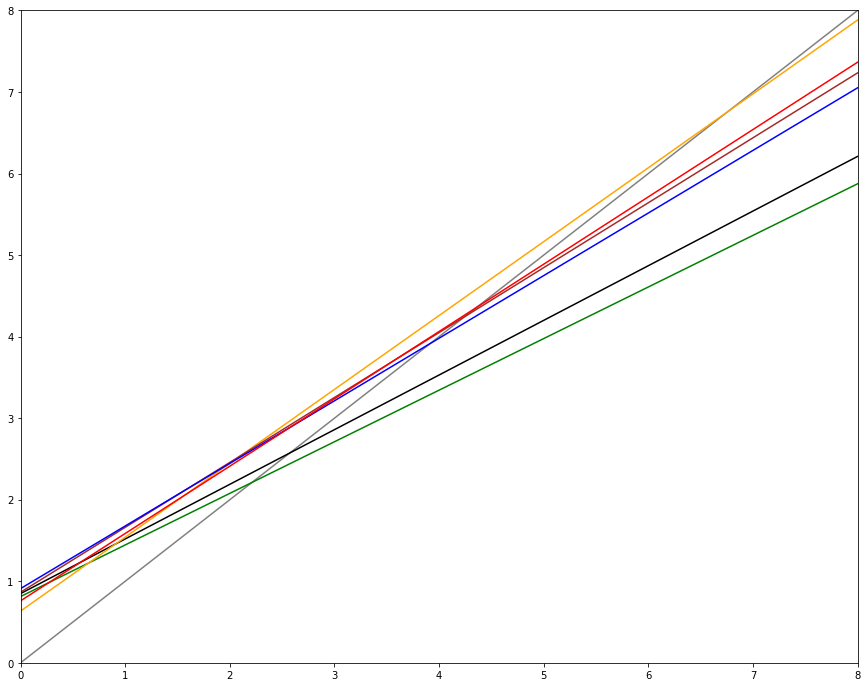

In [6]:
fig=matplotlib.pyplot.figure(figsize=(15, 12))
ax=matplotlib.pyplot.axes()
ax.set_xlim(0.0, 8.0)
ax.set_ylim(0.0, 8.0)
x_vals = np.array(ax.get_xlim())
y_vals = x_vals
ax.plot(x_vals, y_vals, c='grey')

for eps in dfDict: 
    x_vals = np.array(ax.get_xlim())
    y_vals = interceptDict[eps] + slopeDict[eps] * x_vals
    ax.plot(x_vals, y_vals, c=colorMap[eps])
    
matplotlib.pyplot.draw()

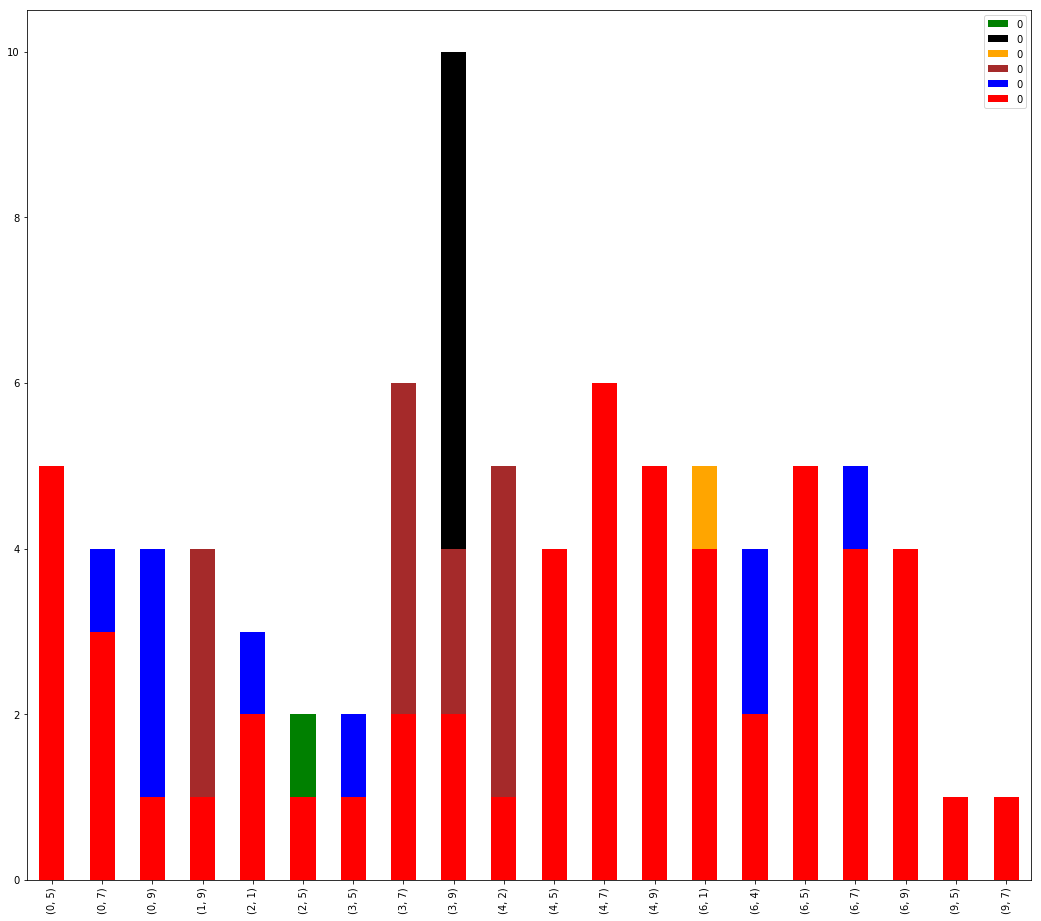

In [7]:
# When is DP much better than no DP?
dpBetterCorrect = {}
dpBetterAdv = {}
dpBetterDict = {}
dpBetterPairs = {}
dpHist = None

for eps in dfDict:
    if eps in ['0.1', '0.2']:
        continue
    
    dpBetterCorrect[eps] = []
    dpBetterAdv[eps] = []
    
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        dpBetterDict[eps] = dfDict[eps][dfDict[eps][epsLabel] >= dfDict[eps][zeroLabel] * 1.5]
        
        dpBetterCorrect[eps].extend(dpBetterDict[eps]["Valid Eps %s Classification" % eps].values)
        dpBetterAdv[eps].extend(dpBetterDict[eps]["Adv%d Eps %s Classification" % (i, eps)].values)

for eps in dpBetterCorrect:
    dpBetterPairs[eps] = [(dpBetterCorrect[eps][i], dpBetterAdv[eps][i]) for i in range(len(dpBetterCorrect[eps]))]
    dpBetterPairs[eps].sort()
    
    dpBetterPairsDF = pd.DataFrame.from_dict(Counter(dpBetterPairs[eps]), orient='index')
    if dpBetterPairsDF.empty:
        continue
    
    if (dpHist is None):
        dpHist = dpBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16))
    else:
        dpBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16), ax=dpHist)
dpHist

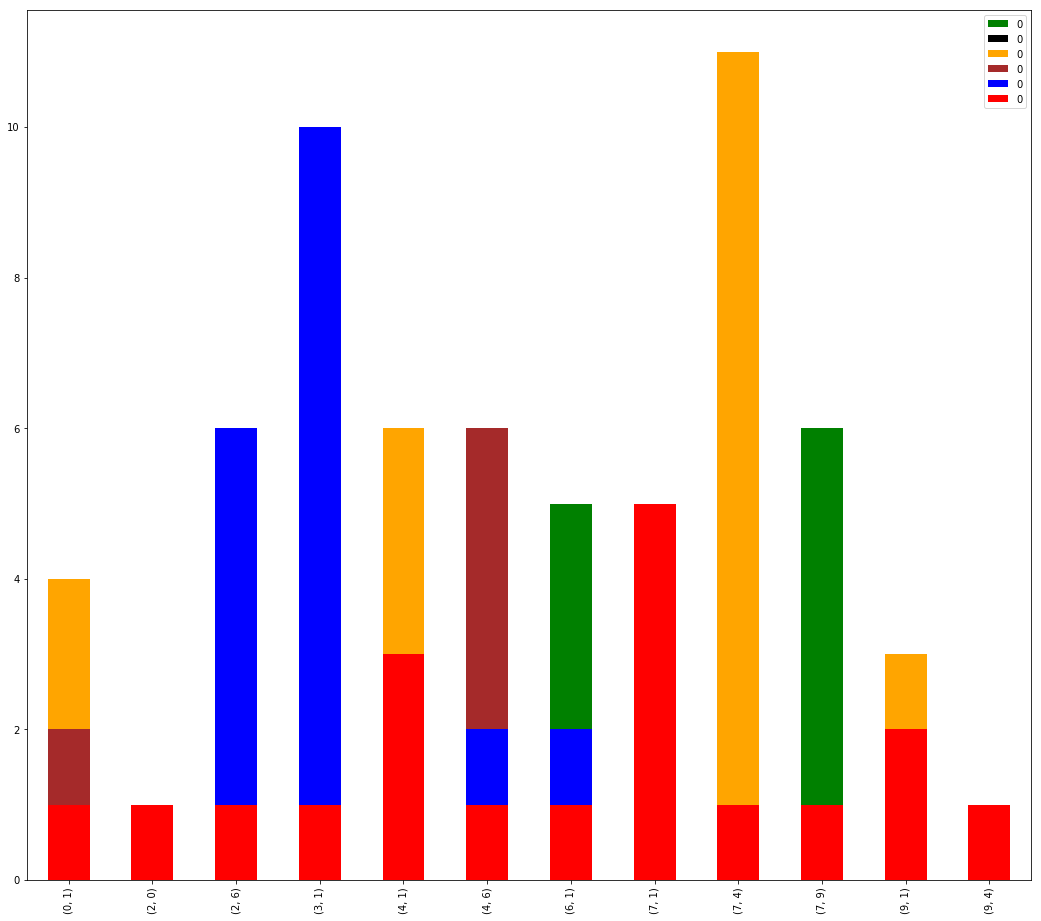

In [8]:
# When is no DP much better than DP?
noDPBetterCorrect = {}
noDPBetterAdv = {}
noDPBetterDict = {}
noDPBetterPairs = {}
noDPHist = None

for eps in dfDict:
    if eps in ['0.1', '0.2']:
        continue
    
    noDPBetterCorrect[eps] = []
    noDPBetterAdv[eps] = []
    
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        noDPBetterDict[eps] = dfDict[eps][dfDict[eps][zeroLabel] >= dfDict[eps][epsLabel] * 1.5]
        
        noDPBetterCorrect[eps].extend(noDPBetterDict[eps]["Valid Eps %s Classification" % eps].values)
        noDPBetterAdv[eps].extend(noDPBetterDict[eps]["Adv%d Eps %s Classification" % (i, eps)].values)

for eps in noDPBetterCorrect:
    noDPBetterPairs[eps] = [(noDPBetterCorrect[eps][i], noDPBetterAdv[eps][i]) for i in range(len(noDPBetterCorrect[eps]))]
    noDPBetterPairs[eps].sort()
    
    noDPBetterPairsDF = pd.DataFrame.from_dict(Counter(noDPBetterPairs[eps]), orient='index')
    if noDPBetterPairsDF.empty:
        continue
    
    if (noDPHist is None):
        noDPHist = noDPBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16))
    else:
        noDPBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16), ax=noDPHist)
noDPHist